In [ ]:
import tensorflow as tf
import PIL
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, classification_report
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, concatenate
from keras.layers import RandomRotation, RandomFlip, RandomCrop, RandomContrast, RandomZoom
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, Callback
from functools import partial
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_dir = "/content/drive/MyDrive/Project/Landmarks-v1_1"

d = {"image_name":[],"image_pixels":[], "category":[],"landmark":[]}

cnt = 0
for category in os.scandir(img_dir):
    if os.path.isdir(category):
        for landmark in os.scandir(category):
            if os.path.isdir(landmark):
                for img in os.scandir(landmark):
                    cnt+=1
                    try:
                        img_path = os.path.abspath(img)
                        img_data = PIL.Image.open(img_path)
                        img_data = img_data.resize((224,224))

                        if img_data.mode != 'RGB':
                            print("Converting from Grayscale to RGB:",img_path,"\n")
                            img_data = img_data.convert('RGB')

                        d["image_pixels"].append(np.array(img_data))
                        d["image_name"].append(img_path[img_path.rfind('/')+1:])
                        d["category"].append(category.name)
                        d["landmark"].append(landmark.name)
                    except:
                        print("Error Reading:",img_path,"\n")
                        continue

Converting from Grayscale to RGB: /content/drive/MyDrive/Project/Landmarks-v1_1/Mughal/Tomb of I_timad-ud-Daulah/Tomb of I_timad-ud-Daulah - 4.jpg 

Converting from Grayscale to RGB: /content/drive/MyDrive/Project/Landmarks-v1_1/Mughal/Tomb of I_timad-ud-Daulah/Tomb of I_timad-ud-Daulah - 7.png 



In [ ]:
df = pd.DataFrame(d)

le_category = LabelEncoder()
le_category.fit(df["category"])
print("Categories:",[(int(np.where(le_category.classes_==c)[0]),c) for c in le_category.classes_])
print()
df["category"] = le_category.transform(df["category"])

le_landmark = LabelEncoder()
le_landmark.fit(df["landmark"])
df["landmark"] = le_landmark.transform(df["landmark"])
print("Landmarks:",[(int(np.where(le_landmark.classes_==c)[0]),c) for c in le_landmark.classes_])

df.head()

Categories: [(0, 'Gothic'), (1, 'Modern'), (2, 'Mughal'), (3, 'Neoclassical'), (4, 'Pagodas'), (5, 'Pyramids')]

Landmarks: [(0, 'Academy of Athens'), (1, 'Bibi Ka Maqbara'), (2, 'Buckingham Palace'), (3, 'CCTV Headquarters'), (4, 'Cathedral of Brasília'), (5, 'ChartresCathedral'), (6, 'Chrysler Building'), (7, 'CologneCathedral'), (8, 'Concertgebouw'), (9, 'El Castillo, Chichen Itza'), (10, 'FogongTemplePagoda'), (11, 'GiantWildGoosePagoda'), (12, 'Hallgrímskirkja'), (13, 'Jama Masjid'), (14, 'Louvre Pyramid'), (15, 'MilanCathedral'), (16, 'Notre-DameCathedral'), (17, 'Panthéon'), (18, 'Pyramid of Djoser'), (19, 'Pyramid of Giza'), (20, 'Ripon Building'), (21, 'Santa Cecilia Acatitlan Pyramid'), (22, 'ShwedagonPagoda'), (23, 'St.VitusCathedral'), (24, 'Taj Mahal'), (25, 'ThienMuPagoda'), (26, 'TianningTemplePagoda'), (27, 'Tomb of Akbar'), (28, 'Tomb of I_timad-ud-Daulah'), (29, 'eiffel')]


,image_name,image_pixels,category,landmark
0,Panthéon_12.jpeg,"[[[108, 136, 202], [109, 135, 202], [110, 134,...",3,17
1,Panthéon_4.jpg,"[[[43, 120, 208], [43, 120, 208], [43, 120, 20...",3,17
2,Panthéon_6.jpeg,"[[[81, 111, 139], [79, 109, 137], [79, 109, 13...",3,17
3,Panthéon_9.jpeg,"[[[79, 130, 173], [81, 132, 175], [79, 130, 17...",3,17
4,Panthéon_16.jpeg,"[[[63, 96, 201], [63, 96, 201], [63, 96, 201],...",3,17


In [ ]:
X = list(df["image_pixels"].values)

y_c = list(df["category"].values)
class_names_c = le_category.classes_
y_l = list(df["landmark"].values)
class_names_l = le_landmark.classes_
# +["other"]

X_train_full, X_test, y_train_full_c, y_test_c, y_train_full_l, y_test_l = train_test_split(X, y_c, y_l, test_size=0.1, random_state=42)
X_train_full, X_test, y_train_full_c, y_test_c, y_train_full_l, y_test_l = np.array(X_train_full), np.array(X_test), np.array(y_train_full_c), np.array(y_test_c),np.array(y_train_full_l), np.array(y_test_l)

X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

split_index = int(0.9 * len(X_train_full))
X_train, y_train_c, y_train_l = X_train_full[:split_index], y_train_full_c[:split_index], y_train_full_l[:split_index]
X_valid, y_valid_c, y_valid_l = X_train_full[split_index:], y_train_full_c[split_index:], y_train_full_l[split_index:]

In [ ]:
# from tensorflow.keras.layers import MaxPooling2D, BatchNormalization

# Define the VGG16 model with pre-trained weights
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the VGG16 base model
for layer in vgg16_base.layers[:15]:
    layer.trainable = False
for layer in vgg16_base.layers[15:]:
    layer.trainable = True

data_augmentation = [
    RandomRotation(factor=0.3, seed=42),
    RandomFlip(),
    #RandomHorizontalFlip(seed=42),
    #RandomContrast(factor=0.2, seed=42),
    RandomCrop(122,122),
    #RandomZoom(0.4,0.2)
]

x = Input(shape=(224,224,3))
for layer in data_augmentation:
    x = layer(x)

x = vgg16_base.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Define the multi-output model
dense1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
output_l = Dense(30, activation='softmax', name='landmark_output')(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
concatenated_input = concatenate([dense2, dense1])
dense3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated_input)
output_c = Dense(6, activation='softmax', name='category_output')(dense3)

model = Model(inputs=vgg16_base.input, outputs=[output_l, output_c])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
# Fit the model with input and output data for each output
history = model.fit(X_train, [y_train_l,y_train_c],
                    validation_data= (X_valid, [y_valid_l, y_valid_c]),
                    epochs=400,
                    batch_size=20)

Epoch 1/400
22/22 [==============================] - 15s 405ms/step - loss: 7.7477 - landmark_output_loss: 3.5757 - category_output_loss: 1.9721 - landmark_output_accuracy: 0.0457 - category_output_accuracy: 0.1918 - val_loss: 7.2974 - val_landmark_output_loss: 3.3612 - val_category_output_loss: 1.7485 - val_landmark_output_accuracy: 0.0612 - val_category_output_accuracy: 0.2653
Epoch 2/400
22/22 [==============================] - 3s 136ms/step - loss: 7.3450 - landmark_output_loss: 3.3907 - category_output_loss: 1.7778 - landmark_output_accuracy: 0.0776 - category_output_accuracy: 0.2100 - val_loss: 7.2370 - val_landmark_output_loss: 3.3452 - val_category_output_loss: 1.7277 - val_landmark_output_accuracy: 0.0204 - val_category_output_accuracy: 0.3061
Epoch 3/400
22/22 [==============================] - 3s 137ms/step - loss: 7.1109 - landmark_output_loss: 3.2757 - category_output_loss: 1.6824 - landmark_output_accuracy: 0.0731 - category_output_accuracy: 0.2489 - val_loss: 7.0952 - va

In [ ]:
df_category_a = pd.DataFrame(history.history)[["category_output_loss","val_category_output_loss"]]
df_landmark_a = pd.DataFrame(history.history)[["landmark_output_loss","val_landmark_output_loss"]]

df_category_b = pd.DataFrame(history.history)[["category_output_accuracy","val_category_output_accuracy"]]
df_landmark_b = pd.DataFrame(history.history)[["landmark_output_accuracy","val_landmark_output_accuracy"]]

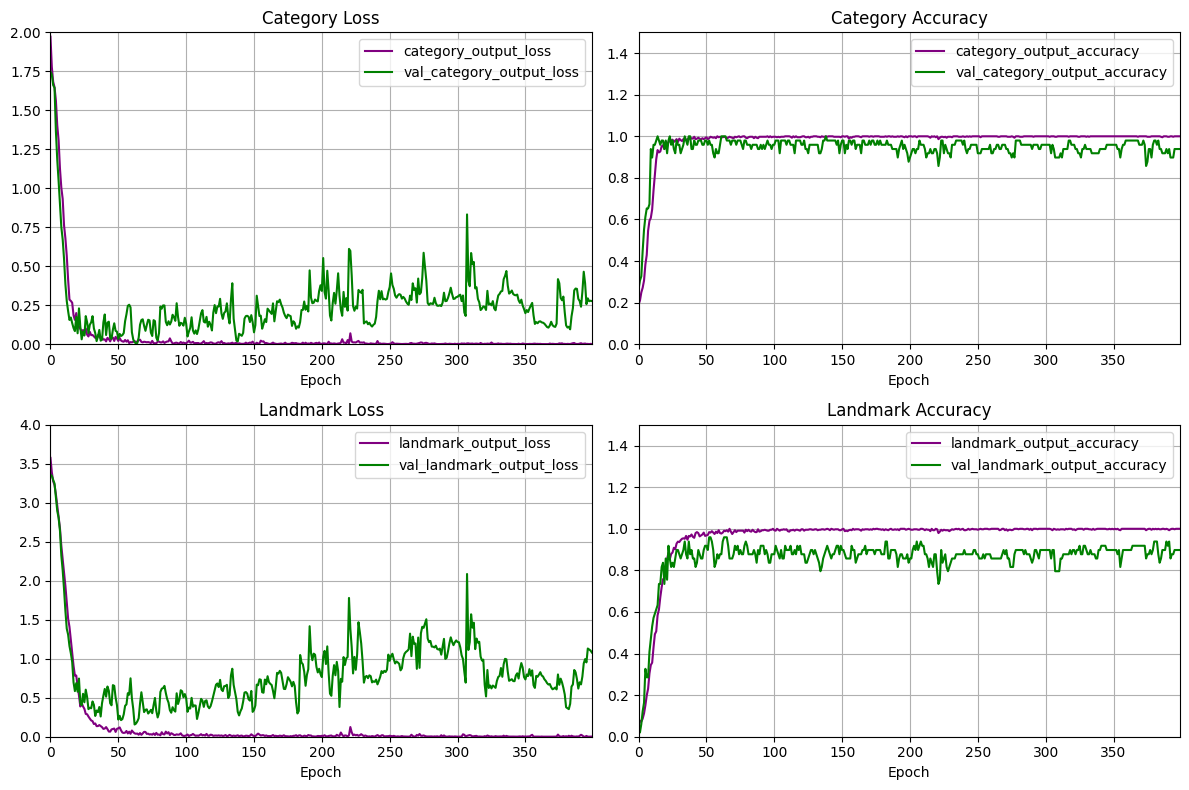

In [ ]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
num_epochs = len(history.history['loss'])

# Plot category A loss and accuracy versus epoch
df_category_a.plot(ax=axs[0], xlim=[0, num_epochs-1], ylim=[0, 2], grid=True, xlabel="Epoch", style=["purple", "green"])
axs[0].set_title("Category Loss")

# Plot category B loss and accuracy versus epoch
df_category_b.plot(ax=axs[1], xlim=[0, num_epochs-1], ylim=[0, 1.5], grid=True, xlabel="Epoch", style=["purple", "green"])
axs[1].set_title("Category Accuracy")

# Plot landmark A loss and accuracy versus epoch
df_landmark_a.plot(ax=axs[2], xlim=[0, num_epochs-1], ylim=[0, 4], grid=True, xlabel="Epoch", style=["purple", "green"])
axs[2].set_title("Landmark Loss")

# Plot landmark B loss and accuracy versus epoch
df_landmark_b.plot(ax=axs[3], xlim=[0, num_epochs-1], ylim=[0, 1.5], grid=True, xlabel="Epoch", style=["purple", "green"])
axs[3].set_title("Landmark Accuracy")

# Adjust spacing between subplots and save the figure
plt.tight_layout()
plt.savefig("9284-loss_accuracy_plot.png")

# Download the figure from Colab
from google.colab import files
# files.download("9284-loss_accuracy_plot.png")

In [ ]:
# Evaluate the model on the test set
loss, test_loss_l, test_loss_c, test_acc_l, test_acc_c = model.evaluate(X_test, [y_test_c, y_test_l])
print("loss:",loss, "test_loss_l:",test_loss_l, "test_loss_c:",test_loss_c, "test_acc_l:",test_acc_l, "test_acc_c:",test_acc_c)

2/2 [==============================] - 8s 3s/step - loss: nan - landmark_output_loss: 26.3860 - category_output_loss: nan - landmark_output_accuracy: 0.0000e+00 - category_output_accuracy: 0.0000e+00
loss: nan test_loss_l: 26.386018753051758 test_loss_c: nan test_acc_l: 0.0 test_acc_c: 0.0


In [ ]:
# Predict the outputs for the test set
y_proba_l, y_proba_c = model.predict(X_test)
y_pred_c = y_proba_c.argmax(axis=-1)
y_pred_l = y_proba_l.argmax(axis=-1)
# y_pred_l = np.where(y_proba_l.max(axis=-1) < 0.06, 30, y_pred_l)

# Calculate the accuracy, precision, and recall for the test set
def my_metrics(y_test, y_pred, class_names):
    # Calculate the accuracy, precision, and recall for the test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Convert the scores to percentages
    accuracy_pct = accuracy * 100
    precision_pct = precision * 100
    recall_pct = recall * 100
    f1_pct = f1 * 100

    # Print the accuracy, precision, and recall for the test set as percentages
    print("Test Accuracy: {:.2f}%".format(accuracy_pct))
    print("Test Precision: {:.2f}%".format(precision_pct))
    print("Test Recall: {:.2f}%".format(recall_pct))
    print("Test F1 score: {:.2f}%".format(f1_pct))

    # target_names = [f"Class {i} ({class_names[i]})" for i in range(len(class_names))]
    # report = classification_report(y_test, y_pred, target_names=target_names)
    # print(report)

print("\nCategory Classification:")
my_metrics(y_test_c, y_pred_c, class_names_c)
print("\nLandmark Classification:")
my_metrics(y_test_l, y_pred_l, class_names_l)

2/2 [==============================] - 0s 123ms/step

Category Classification:
Test Accuracy: 92.73%
Test Precision: 92.02%
Test Recall: 93.45%
Test F1 score: 92.30%

Landmark Classification:
Test Accuracy: 90.91%
Test Precision: 92.86%
Test Recall: 92.03%
Test F1 score: 90.39%


In [ ]:
model.save('model_new12.h5')

In [ ]:
from google.colab import files

# Replace 'model.h5' with your own file name
files.download('model_new12.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import PIL
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, classification_report
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, concatenate
from keras.layers import RandomRotation, RandomFlip, RandomCrop, RandomContrast, RandomZoom#, RandomShear
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, Callback
from functools import partial
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import VGG16
from sklearn.utils import compute_class_weight

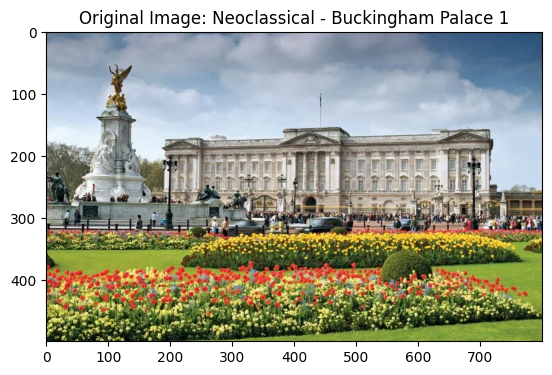

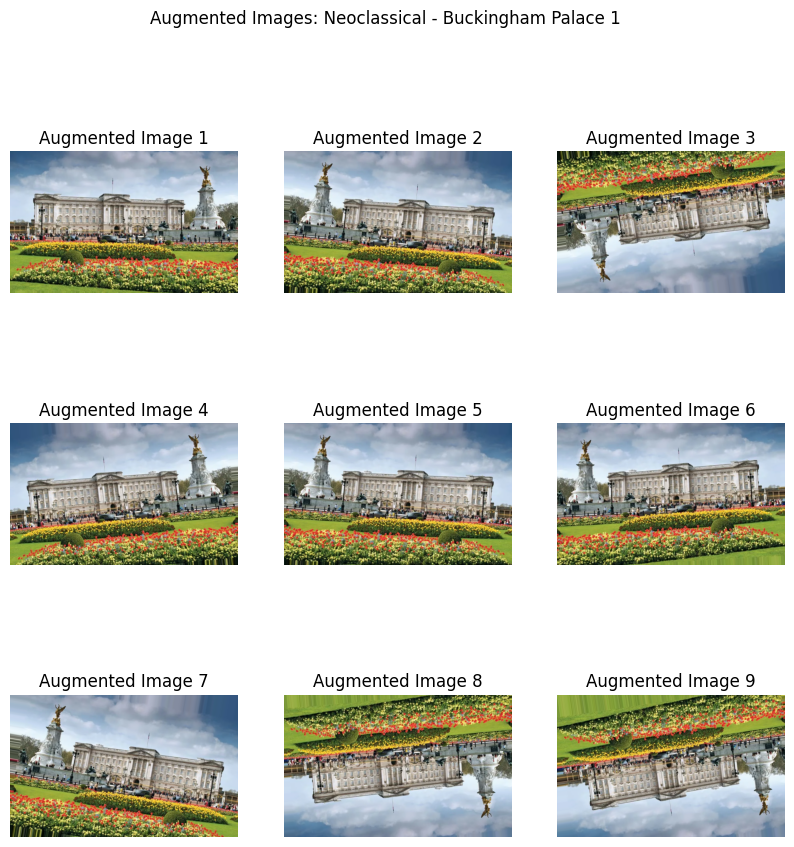

In [ ]:
# Load an example image
img_path = "/content/drive/MyDrive/Project/Landmarks-v1_1/Neoclassical/Buckingham Palace/Buckingham Palace_1.jpg"
img = load_img(img_path)

# Display the original image
plt.figure()
plt.imshow(img)
plt.title("Original Image: Neoclassical - Buckingham Palace 1")

data_augmentation = ImageDataGenerator(
    rotation_range=10,          #RandomRotation
    horizontal_flip=True,       #RandomZoom
    vertical_flip=True,         #RandomZoom
    # target_size = (122,122),     #RandomCrop
)

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Reshape the array to match the expected input shape for the ImageDataGenerator
img_array = img_array.reshape((1,) + img_array.shape)

# Generate augmented images from the original image
augmented_images = data_augmentation.flow(img_array)

# Plot the augmented images
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for row in range(3):
    for col in range(3):
        img = augmented_images.next().squeeze().astype(np.uint8)
        ax[row][col].imshow(img)
        ax[row][col].axis('off')
        ax[row][col].set_title("Augmented Image {}".format(row*3+col+1))

plt.suptitle("Augmented Images: Neoclassical - Buckingham Palace 1")
plt.show()